## SIMULAÇÃO LINHA ATUAL 

IMPORTS

In [6]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

### ETAPA 1 - Obtendo informações de tempo do Yamazumi

In [7]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 02: Criando dicionário de tempos por posto

##### Configuração perna 1: 
19 operadores no total sendo 1 por atividade, com excessões: 
- DIESEL - 30A  
- ARREFEC - 31A  
- REAPERTO - 32A  
- 5AA_RODA - 32C (só ATP)  
- ESTEPE - 32C  
- PNEU_LE + PNEU_LD - 33A (2 operadores)  
- APERTO_LE + APERTO_LD - 34A (2 operadores)  
- GRADE- 34A  
- MECACNICA_1 + MECACNICA_2 - Início: 34A; Fim: 38 (2 operadores)  
- ELECTRICA_1 + ELECTRICA_2 - Início: 32A; Fim: 33A (2 operadores)  
- CONTROLE - 34A  
- MOTORISTA - 38  
- QUIS - 38  




##### Configuração perna 2:
13 operadores no total sendo 1 por atividade, com excessões: 
- PASSADISASSO - 30B 
- ABASTECIMENTO - 31B   
- CHINELEIRA - 32B  
- 5AA_RODA - 32D  
- PNEU_LE + PNEU_LD - 33B (2 operadores)  
- PARALAMA_LD + PARALAMA_LE - 34B (1 op)  
Paralama e pneu é feito ao mesmo tempo, assim, tempo paralama conta como 1
- CONTROLE - 34B 
- ELACTRICA_I + ELACTRICA_II + ELACTRICA_III - Início: 33B; Fim: 39 (3 operadores)  
Na elétrica, podemos considerar como se 1 operador fizesse 1 atvidade total distribuída pelos 3 postos  


In [10]:

# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              }

ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}
              }


In [2]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    POSTOS = {}

    GRUPOS_ESPECIAIS = {
        'P1': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
            'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
            'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"}
        },
        'P2': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
            'ELETRICA': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II', 'ELACTRICA_III'], "agreg": "media"}
        }
    }

    for modelo, dados_modelo in MODELOS_CSV.items():
        perna = dados_modelo["perna"]
        arquivo = dados_modelo["tempos"]
        tempos_atividade = get_process_times_from_csv(arquivo)
        
        print(tempos_atividade)
        
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2
        grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

        dicionario_postos = {}

        # Aplica regras especiais por grupo
        for nome_grupo, grupo in grupos.items():
            atividades = grupo["atividades"]

            if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
                continue  # ignora se alguma atividade do grupo não existe

            if grupo["agreg"] == "media":
                tempo_total = sum(tempos_atividade[a] / atividades_dict[a]['operadores'] for a in atividades)
                tempo = tempo_total / len(atividades)
            elif grupo["agreg"] == "paralama":
                tempo_total = sum(tempos_atividade[a] for a in atividades)
                total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades)
                tempo = tempo_total / (total_operadores/2)
            else:
                continue

            # aplica tempo dividido entre os postos das atividades
            postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
            for posto in postos_grupo:
                dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
                dicionario_postos[posto]["tempo_tot"] += tempo / len(postos_grupo)

        # adiciona atividades individuais
        for atividade, props in atividades_dict.items():
            if modelo not in props['modelos']:
                continue
            if atividade not in tempos_atividade:
                continue

            tempo = tempos_atividade[atividade] / props['operadores']
            for posto in props['postos']:
                dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
                dicionario_postos[posto]["tempo_tot"] += tempo

        # ordena os postos
        postos_ordenados = {}
        for posto in ordem_postos:
            if posto in dicionario_postos:
                postos_ordenados[posto] = dicionario_postos[posto]

        POSTOS[modelo] = postos_ordenados

    return POSTOS


In [9]:
POSTOS = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
print("\n--- Tempos por posto por modelo ---")
for modelo, valor in POSTOS.items():
    print(f"{modelo}: {valor}")

{'ARREFEC': 316, 'DIESEL': 253, 'REAPERTO': 235, 'ESTEPE': 290, 'PNEU_LD': 250, 'PNEU_LE': 250, 'APERTO_LD': 304, 'APERTO_LE': 304, 'GRADE': 270, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 357, 'ELACTRICA_2': 357, 'CONTROLE': 265, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 314, 'DIESEL': 314, 'REAPERTO': 294, 'ESTEPE': 267, 'PNEU_LD': 308, 'PNEU_LE': 308, 'APERTO_LD': 315, 'APERTO_LE': 315, 'GRADE': 234, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 330, 'DIESEL': 326, 'REAPERTO': 557, '5AA_RODA': 724, 'ESTEPE': 319, 'PNEU_LD': 256, 'PNEU_LE': 256, 'APERTO_LD': 323, 'APERTO_LE': 323, 'GRADE': 230, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ABASTECIMENTO': 555, 'PASSADISASSO': 752, 'CHINELEIRA': 965, '5AA_RODA': 988, 'PNEU_LD': 407, 'PNEU_LE': 407, 'PARALAMA_LD': 800, 'PARALAMA_LE': 800, 'CONTROLE

### ETAPA 03: Processamento da simulação 

In [3]:
TAKT_TIME=5.5*60
TURN_DURATION=14*3600

# Função PROCESSAR_MODELO() simula a trajetória de um modelo pela linha de montagem:
# env é o ambiente de simulação do SimPy.
# nome é o nome único desse modelo na simulação, ex: "Actros_5".
# postos_dict é um dicionário com os postos que esse modelo vai passar, com tempos por posto.

log_entrada_saida=[]
def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_tot"]
        with recursos[posto].request() as req: # pede o recurso do posto (garante que só um modelo usa por vez)
            entrada = env.now
            yield req #espera se necessário (yield req)
            yield env.timeout(tempo_tot) # espera o tempo de montagem (yield env.timeout(tempo_tot))
            saida = env.now

            # registra entrada, saída e duração no log
            log_entrada_saida.append({
                "modelo": modelo_nome,
                "nome": nome,
                "posto": posto,
                "entrada": entrada,
                "saida": saida,
                "duracao": saida - entrada,
                "perna": perna
            })

# Função SIMULACAO_LINHA cria o ambiente da simulação
# recursos: dicionário onde cada posto é um simpy.Resource() com capacity=1.
# ultimo_tempo_entrada_global: impede que dois modelos entrem no mesmo instante.
# disponibilidade_postos: controla quando o primeiro posto da perna estará livre para o próximo veículo.

def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

    env = simpy.Environment() # criando ambiente simulação
    
    # Ferramentas auxiliares na função:
    recursos = {} # dicionário onde cada posto é um simpy.Resource() com capacity=1;nenhum posto pode ser ocupado por mais de um modelo
    ultimo_tempo_entrada_global = 0  # ninguém entra na linha antes disso, impede que dois modelos entrem no mesmo instante nas pernas
    disponibilidade_postos = {}  # armazena quando o primeiro posto de cada perna estará livre para próximo veículo entrar

    # Função ALIMENTADOR() coloca os modelos na linha, respeitando o espaçamento (TAKT) e disponibilidade do primeiro posto.
    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        # Identificando qual modelo corresponde ao baumuster da sequência e sua perna
        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, perna = None, None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    perna = dados["perna"]
                    break
            if modelo_nome is None:
                continue
            
            # Define o primeiro posto que o modelo ocupará e quanto tempo levará nesse posto
            postos_dict = resultado[modelo_nome]
            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_tot"]

            # Inicializa a disponibilidade se for a primeira vez usando esse posto
            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0
            
            # só entra um modelo por vez no primeiro posto de cada perna;
            # o espaçamento entre modelos é de ao menos TAKT_TIME;
            # respeita o tempo mínimo em que o posto estará livre.

            # Espera até que seja possível entrar na linha
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,  # garante espaçamento global
                tempo_disponivel_posto  # garante que o primeiro posto da perna está livre
            )

            yield env.timeout(entrada_sugerida - env.now)

            # Atualiza os controles de entrada
            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # Cria os recursos dos postos, se necessário (caso não tenha sido criado)
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            # Inicia processo de montagem
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos
            ))
    
    # Inicia simulação, rodando até duração do turno
    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    return pd.DataFrame(log_entrada_saida)


### ETAPA 04 : Criando funções de resposta gráfica  

In [ ]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [ ]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(10, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [ ]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [ ]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [ ]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [ ]:
def plot_boxplot_tempo_total_por_modelo(df_log):
    """
    Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
    Retorna a figura para posterior salvamento.
    """
    # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
    df_tempo_modelos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        tempo_total_min=("duracao", "sum")
    ).reset_index()

    df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

    ax.set_title("Distribuição do Tempo de Produção por Modelo")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Tempo Total de Produção (minutos)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    fig.tight_layout()
    return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [8]:
# GRÁFICO ESPECIAL INDEPENDE DE DFLOG
def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    # 1. Construir a lista de dados com tempos por modelo, atividade e posto
    for modelo, props in MODELOS_CSV.items():
        perna = props["perna"]
        arquivo = props["tempos"]
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2

        tempos_atividade = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        for atividade, dados in atividades_dict.items():
            if modelo not in dados["modelos"]:
                continue

            tempo_total = tempos_atividade.get(atividade, 0)
            tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

            for posto in dados["postos"]:
                lista_dados.append({
                    "modelo": modelo,
                    "atividade": atividade,
                    "posto": posto,
                    "tempo_min": tempo_por_operador / 60,
                    "perna": perna
                })

    df_atividades = pd.DataFrame(lista_dados)

    def ordenar_por_posto(df, ordem_postos):
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 2. Gerar gráfico para cada modelo
    modelos = df_atividades["modelo"].unique()
    figs =[]
    
    for modelo in modelos:
        df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
        perna = df_modelo["perna"].iloc[0]
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        linha_meta = 5.5 if perna == 1 else 16.5
        
        fig, ax = plt.subplots(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
        plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        plt.title(f"Tempo por Atividade - {modelo}")
        plt.xlabel("Atividade")
        plt.ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        figs.append(fig)

    return figs 


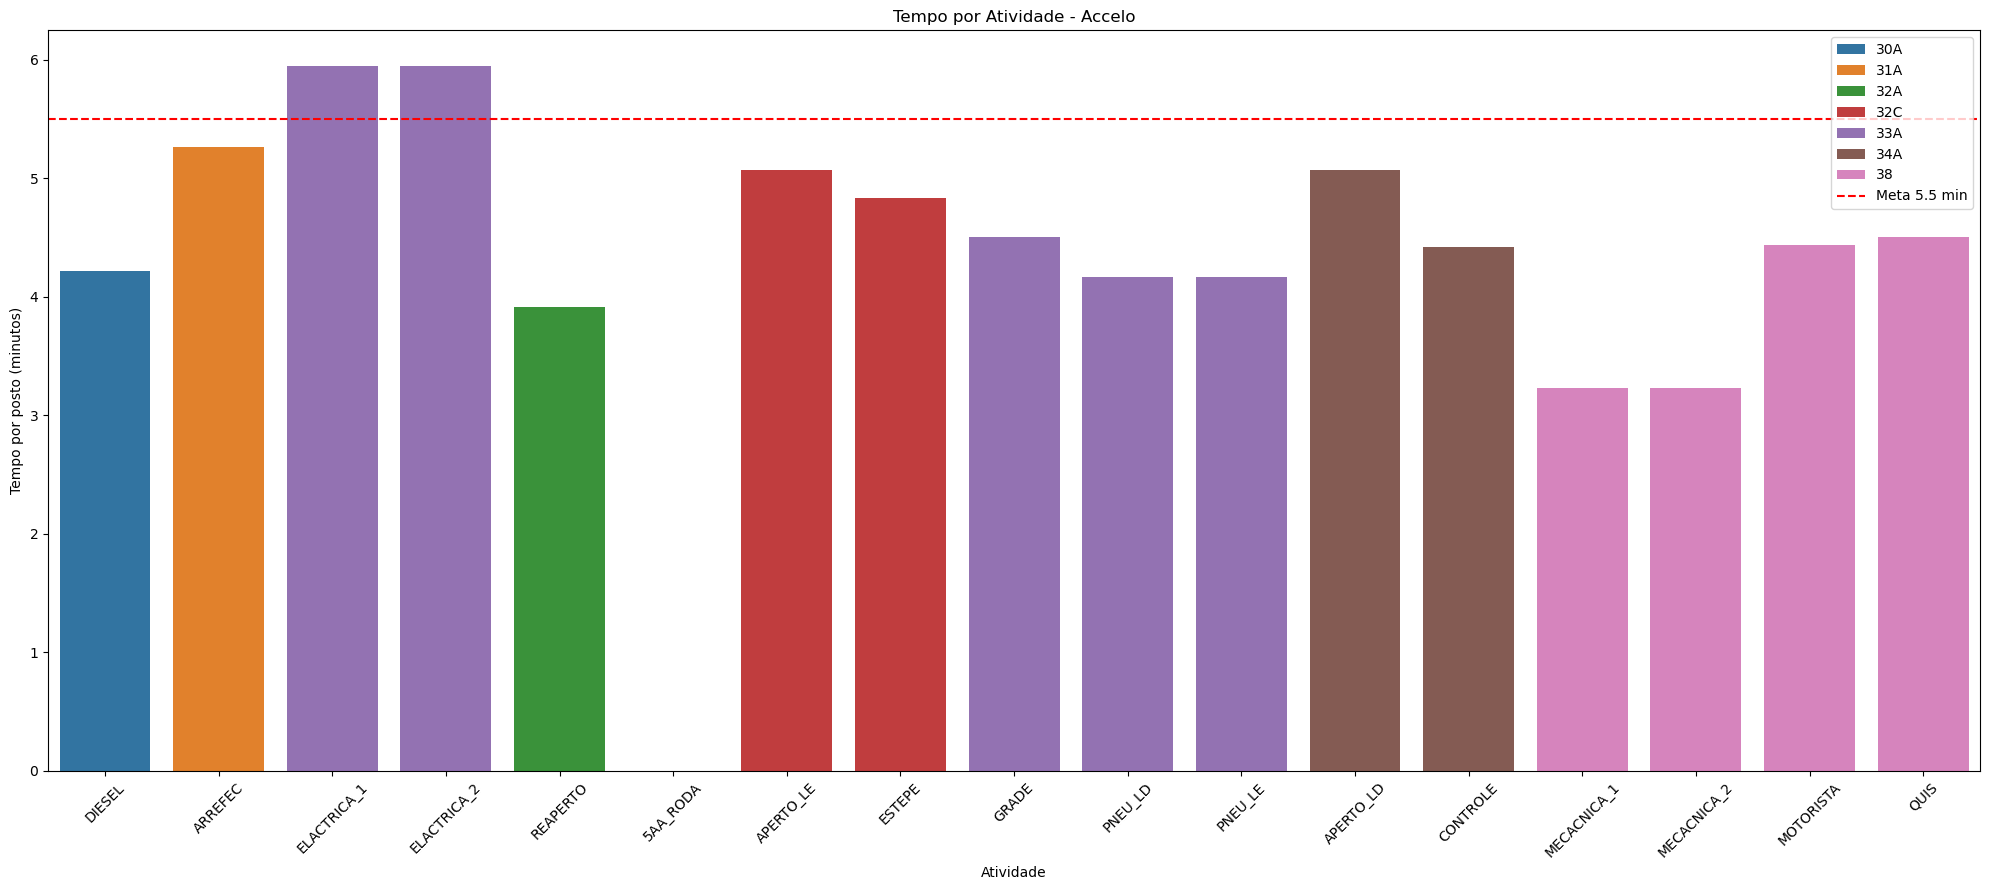

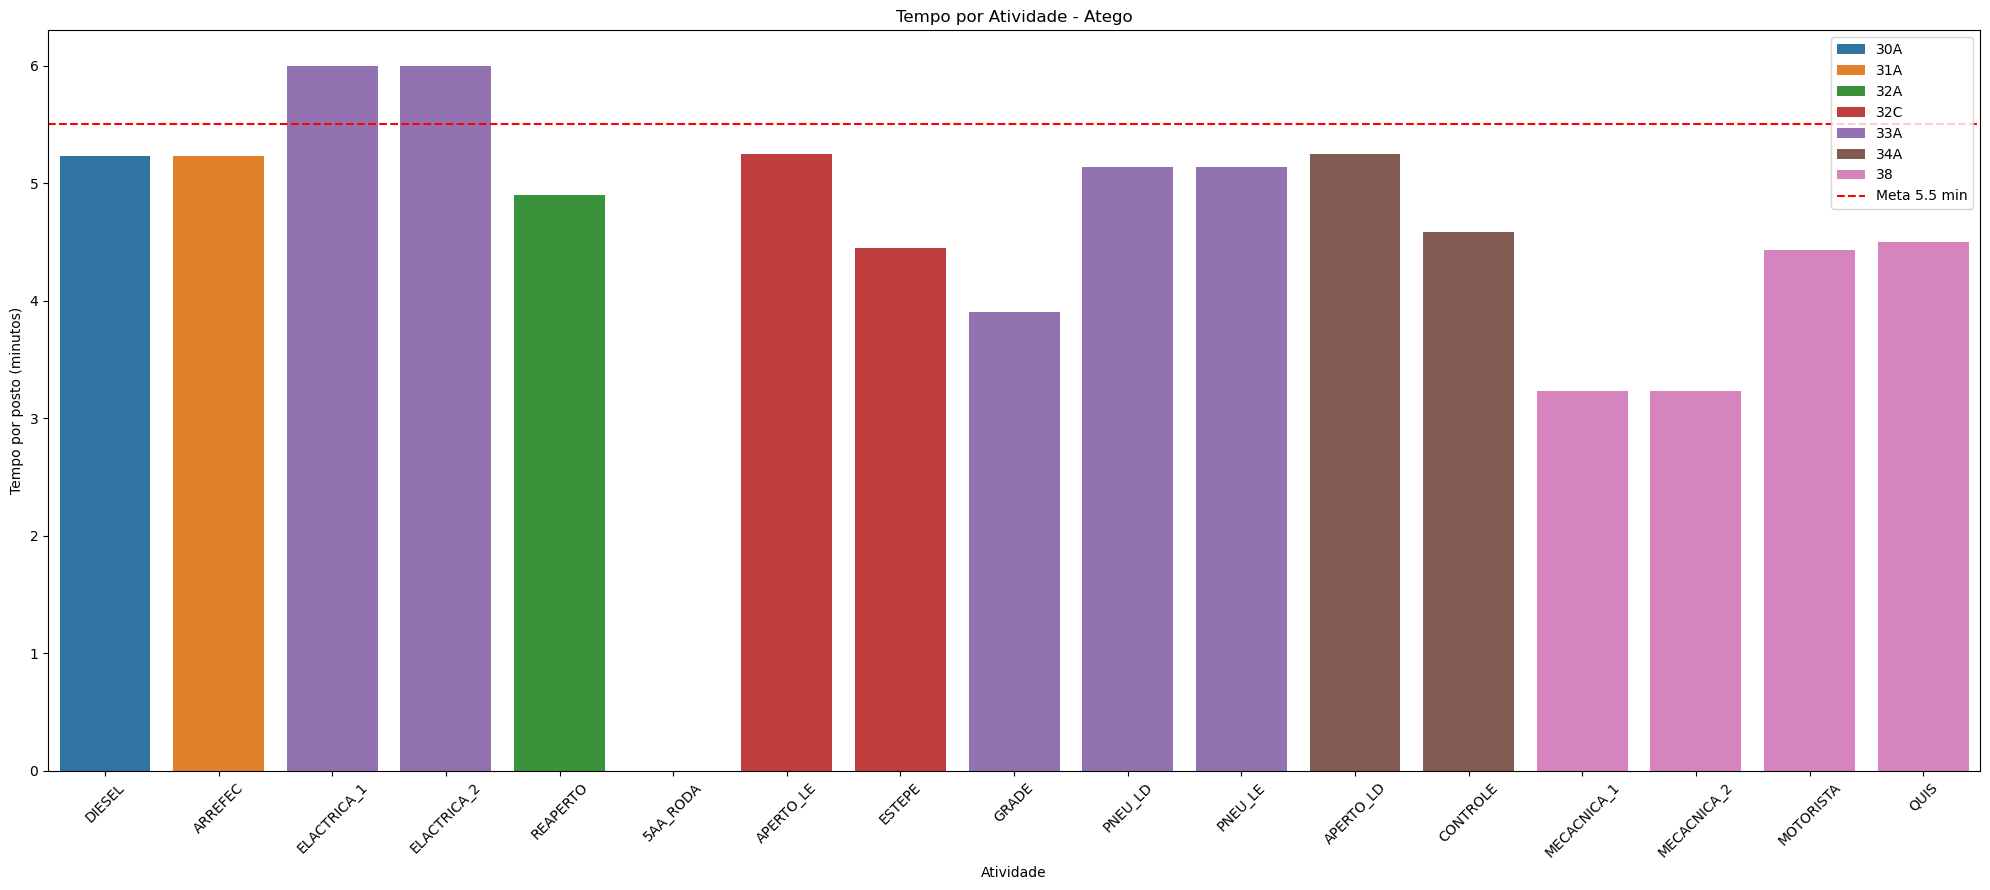

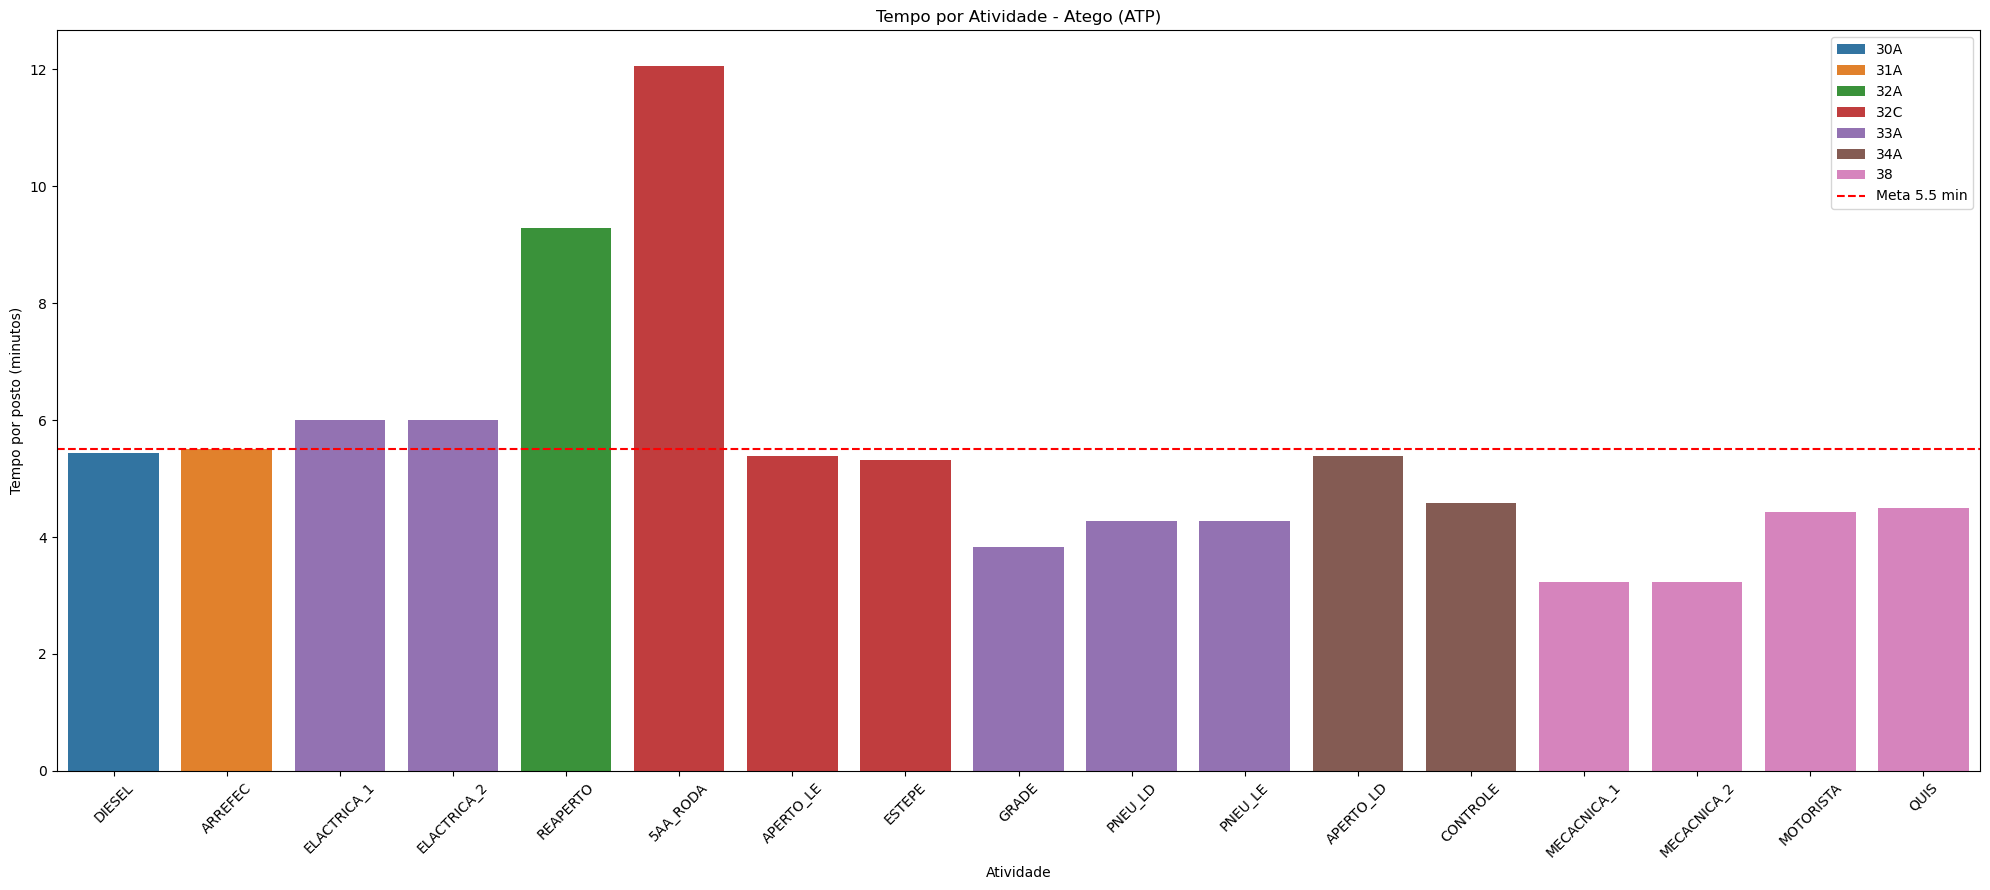

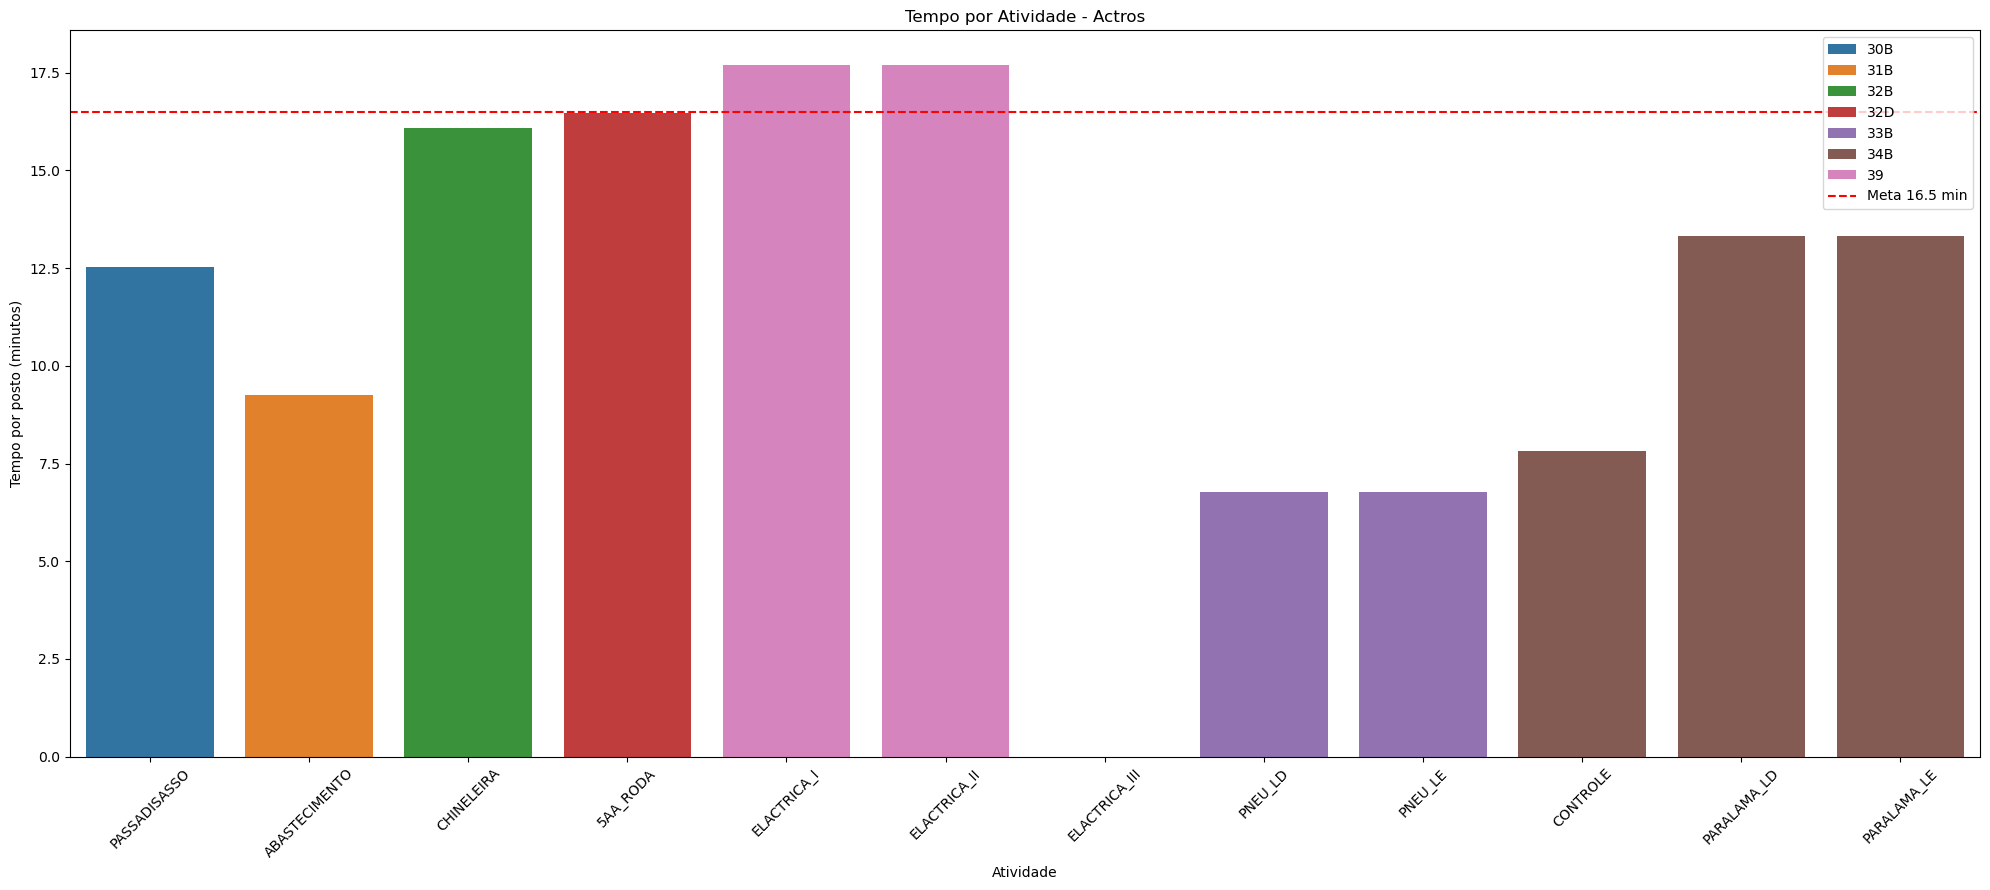

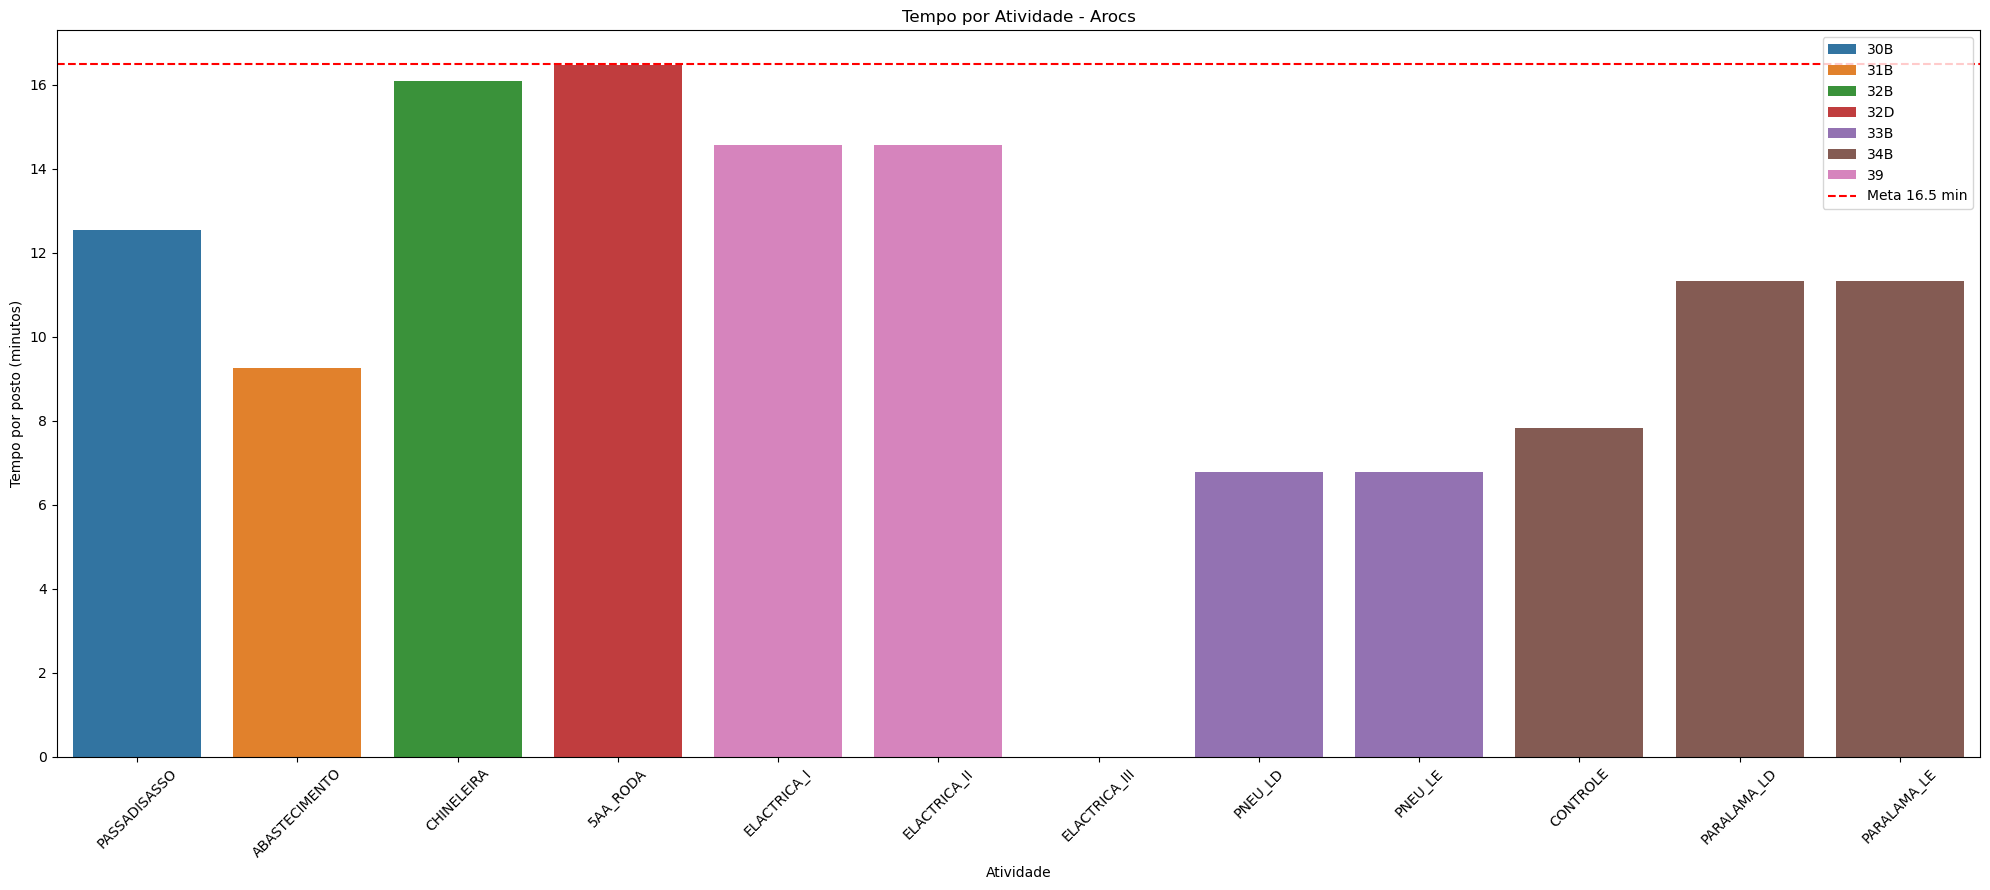

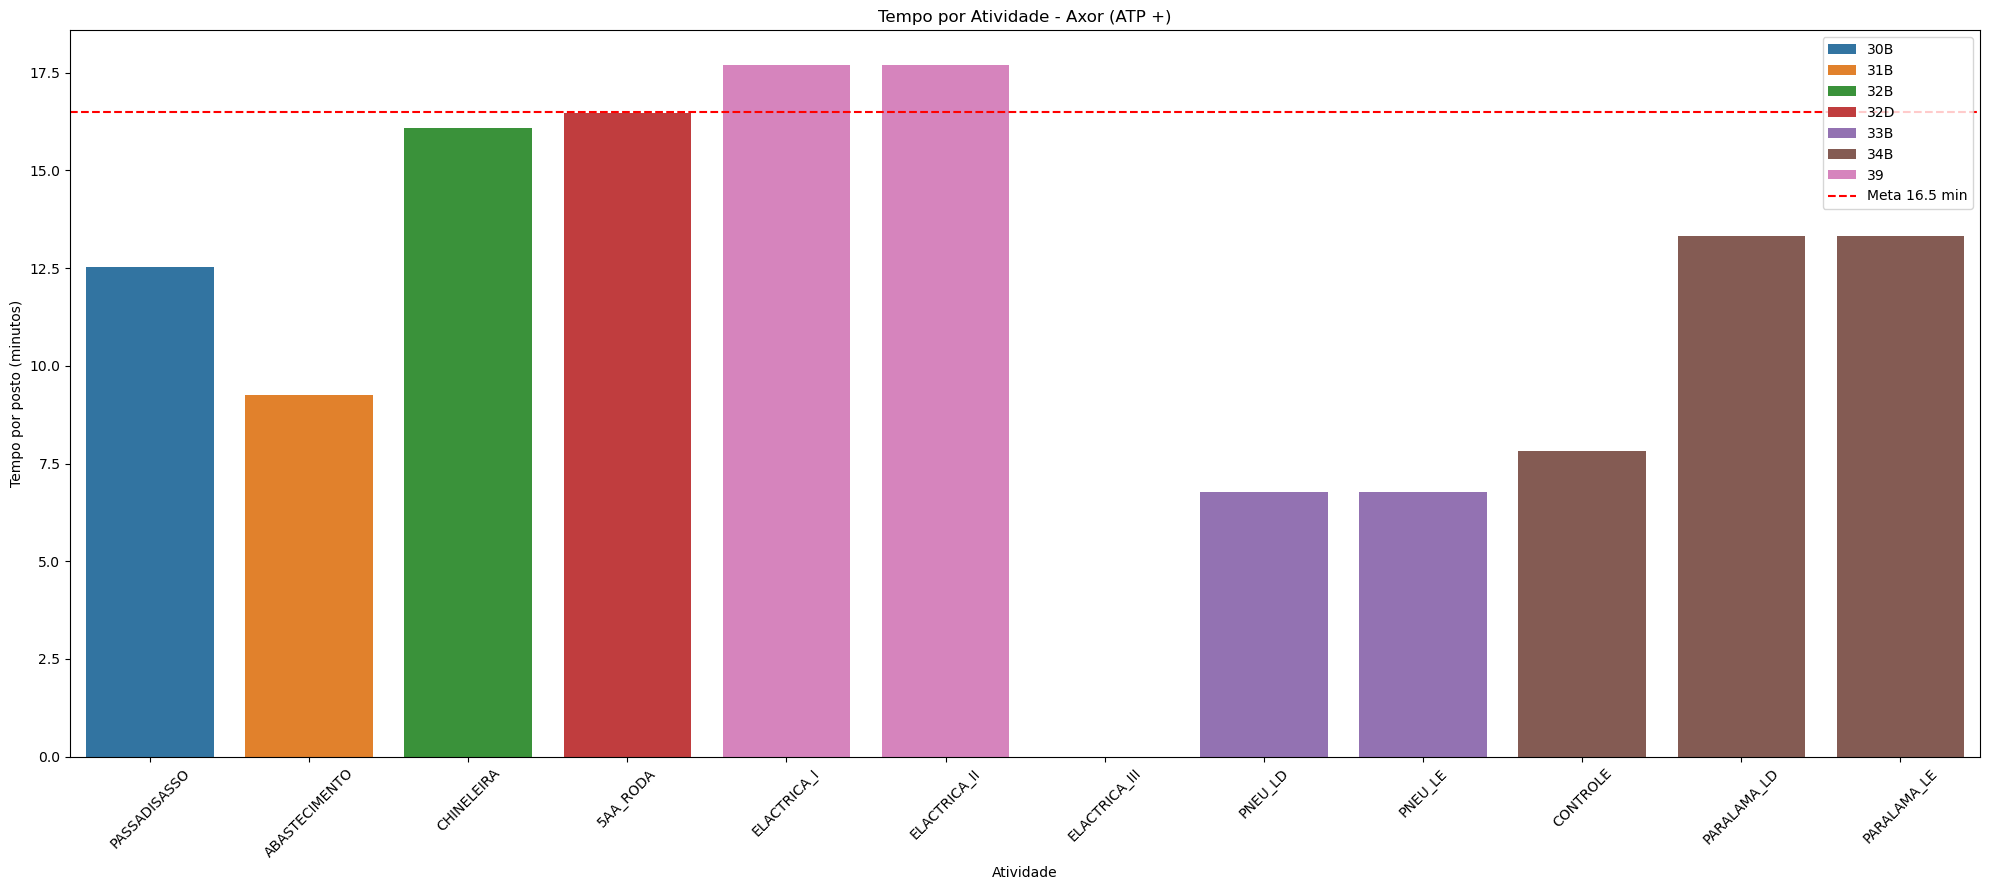

[<Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>]


In [9]:
print(plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv))

Resumo da simulação em pdf

In [ ]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    """

    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio (em minutos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Novo Takt time real por perna (em minutos)
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {qtd} modelos")

    linhas.append("\nTempo médio de produção por modelo:")
    for perna, tempo in tempo_medio_producao.items():
        linhas.append(f"  - Perna {perna}: {tempo:.2f} minutos")

    linhas.append("\nTakt time médio por posto:")
    for perna, takt in takt_time_medio.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    linhas.append("\nNovo Takt time real (TURN_DURATION / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    # 6. Criação do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

In [ ]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("todas_sequencias.xlsx")

# Converte a coluna de data
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'])

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 1)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.unique())

# Filtra os dias a partir da data de início
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:10]

print(f"🗓️ Dias selecionados (10 a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_por_dia_ATUAL", exist_ok=True)

# Salvando tempo por atividades
figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
for i, fig in enumerate(figs, start=1):
    fig.savefig(f"logs_por_dia_ATUAL/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)


# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_por_dia_ATUAL/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # Se já tiver o CSV salvo, pula o dia
    if os.path.exists(nome_csv):
        print(f"✅ Já processado: {dia}")
        continue

    os.makedirs(pasta_dia, exist_ok=True)

    # Filtra dados do dia
    df_dia = df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia].copy()
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str[:7]
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()

    # Simula
    
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento

    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png")

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png")

    figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    
    figs = plot_duracao_media_por_posto(df_log)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    plt.close(fig6)


    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION,caminho_pdf)
